In [1]:
import random

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

In [4]:
x_train.shape, x_test.shape

((60000, 28, 28), (10000, 28, 28))

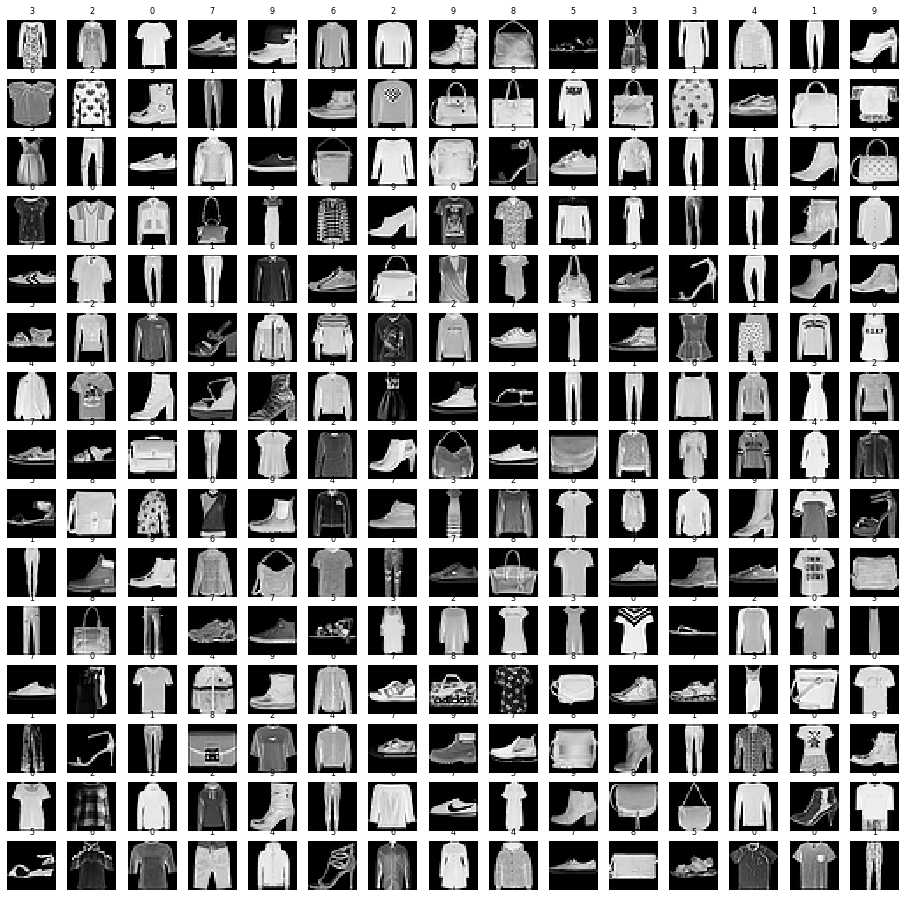

In [8]:
w_grid = 15
l_grid = 15

fig, axes = plt.subplots(w_grid, l_grid, figsize=(16, 16)) # axes is a matrix of w_grid x l_grid size
axes = axes.ravel() # flatten it so that its easy to work on
n_training = len(x_train)

for i in range(w_grid*l_grid):
    index = np.random.randint(0, n_training) # choosing a random image index to plot
    axes[i].imshow(x_train[index], cmap='gray')
    axes[i].set_title(y_train[index], fontsize=8)
    axes[i].axis('off')

In [9]:
# normalize the data
x_train = x_train/255
x_test = x_test/255

In [12]:
noise_factor = 0.3
noise_dataset = []

for image in x_train:
    noise_image = image + noise_factor*np.random.randn(*image.shape) # value MIGHT go more than 1 (which is the max value after normalizing)
    noise_image = np.clip(noise_image, 0, 1) # thats why, clip it
    noise_dataset.append(noise_image)

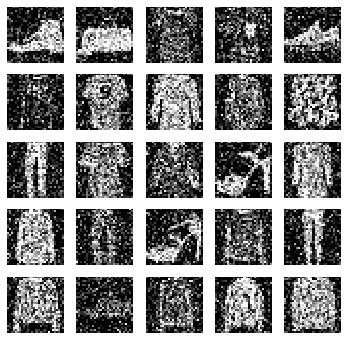

In [17]:
w_grid = 5
l_grid = 5

fig, axes = plt.subplots(w_grid, l_grid, figsize=(6, 6)) # axes is a matrix of w_grid x l_grid size
axes = axes.ravel() # flatten it so that its easy to work on
n_training = len(noise_dataset)

for i in range(w_grid*l_grid):
    index = np.random.randint(0, n_training) # choosing a random image index to plot
    axes[i].imshow(noise_dataset[index], cmap='gray')
    axes[i].axis('off')

In [13]:
noise_factor = 0.2
noise_test_dataset = []

for image in x_test:
    noise_image = image + noise_factor*np.random.randn(*image.shape) # value MIGHT go more than 1 (which is the max value after normalizing)
    noise_image = np.clip(noise_image, 0, 1) # thats why, clip it
    noise_test_dataset.append(noise_image)

In [20]:
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Conv2D, Conv2DTranspose

In [21]:
autoencoder = Sequential()

#encoder
autoencoder.add(Conv2D(16, kernel_size=(3, 3), strides=(2, 2), padding='same', input_shape=(28, 28, 1)))
autoencoder.add(Conv2D(8, kernel_size=(3, 3), strides=(2, 2), padding='same'))
autoencoder.add(Conv2D(8, kernel_size=(3, 3), strides=(1, 1), padding='same'))

#decoder
autoencoder.add(Conv2DTranspose(16, kernel_size=(3, 3), strides=(2, 2), padding='same'))
autoencoder.add(Conv2DTranspose(1, kernel_size=(3, 3), strides=(2, 2), padding='same', activation='sigmoid'))

In [22]:
autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy')
autoencoder.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 14, 14, 16)        160       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 7, 7, 8)           1160      
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 7, 7, 8)           584       
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 14, 14, 16)        1168      
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 28, 28, 1)         145       
Total params: 3,217
Trainable params: 3,217
Non-trainable params: 0
_________________________________________________________________


## *Note*: the INPUT and OUTPUT shape of the model is the same

In [23]:
noise_dataset = np.array(noise_dataset)
noise_test_dataset = np.array(noise_test_dataset)

In [25]:
noise_dataset = noise_dataset.reshape(-1, 28, 28, 1)
noise_test_dataset = noise_test_dataset.reshape(-1, 28, 28, 1)

x_train = x_train.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)

In [24]:
autoencoder.fit(noise_dataset, # x_train
                x_train, # y_train
                epochs=10, 
                batch_size=200, 
                validation_data=(noise_test_dataset, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 10s 171us/step - loss: 0.3957 - val_loss: 0.3186
Epoch 2/10
60000/60000 [==============================] - 3s 49us/step - loss: 0.3149 - val_loss: 0.3049
Epoch 3/10
60000/60000 [==============================] - 3s 49us/step - loss: 0.3079 - val_loss: 0.3010
Epoch 4/10
60000/60000 [==============================] - 3s 49us/step - loss: 0.3053 - val_loss: 0.2983
Epoch 5/10
60000/60000 [==============================] - 3s 50us/step - loss: 0.3039 - val_loss: 0.2974
Epoch 6/10
60000/60000 [==============================] - 3s 50us/step - loss: 0.3029 - val_loss: 0.2958
Epoch 7/10
60000/60000 [==============================] - 3s 50us/step - loss: 0.3022 - val_loss: 0.2952
Epoch 8/10
60000/60000 [==============================] - 3s 50us/step - loss: 0.3018 - val_loss: 0.2948
Epoch 9/10
60000/60000 [==============================] - 3s 51us/step - loss: 0.3015 - val_loss: 0.2947
Epo

In [27]:
autoencoder.evaluate(noise_test_dataset, x_test)

10000/10000 [==============================] - 1s 80us/step


0.29420661587715147

In [28]:
predicted = autoencoder.predict(noise_test_dataset[:10]) #only taking the first 10 images

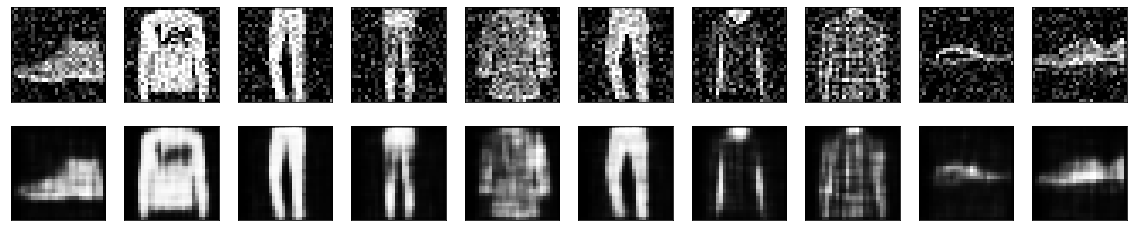

In [30]:
fig, axes = plt.subplots(2, 10, sharex=True, sharey=True, figsize=(20, 4))

for images, row in zip([noise_test_dataset[:10], predicted], axes):
    for image, ax in zip(images, row):
        ax.imshow(image.reshape(28, 28), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)        

#### Model can be trained for more epochs to get better results and The autoencoder can be made more complex for more complex dataset